# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor, plot_importance, to_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import randint, uniform
from IPython.display import Image, display

pd.set_option('display.max_columns', None)

# Configuration

In [2]:
seasons = ['2024-25', '2023-24', '2022-23', '2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16']

In [3]:
target = 'points'

In [4]:
rolling_window = 15

In [5]:
rolling_window_vs_opp = 4

# Prepare Data

In [6]:
# Load data
data_frames = []

for season in seasons:
    df = pd.read_csv(f"data/{season}/processed_{season}.csv")
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

In [7]:
# Sort data based on player and game date
data['gameDate'] = pd.to_datetime(data['gameDate'])

data = data.sort_values('gameDate').reset_index(drop=True)

In [8]:
# Add seconds column
def parse_minutes_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        # Split by colon
        minutes_part, seconds_part = str(time_str).split(':')
        # Convert minute to float, in case it's like "36.000000"
        minutes = float(minutes_part)
        seconds = int(seconds_part)
        total_seconds = int(minutes * 60 + seconds)
        return total_seconds
    except:
        return None
    
data['seconds'] = data['minutes'].apply(parse_minutes_to_seconds)


# Feature Engineering

## Player Rolling

In [9]:
def player_rolling(stat, num_games):
    data[f"{stat}_rolling"] = (
        data.groupby('playerSlug')[stat]
            .transform(lambda x: x.shift().rolling(
                window=num_games,
                min_periods=int(num_games * 0.75 + 0.5)
            ).mean())
    )

In [10]:
player_stats = [
    'seconds',
    'fieldGoalsMade',
    'fieldGoalsAttempted',
    'fieldGoalsPercentage',
    'threePointersMade',
    'threePointersAttempted',
    'threePointersPercentage',
    'freeThrowsMade',
    'freeThrowsAttempted',
    'freeThrowsPercentage',
    'reboundsOffensive',
    'reboundsDefensive',
    'reboundsTotal',
    'assists',
    'steals',
    'blocks',
    'turnovers',
    'foulsPersonal',
    'points',
    'plusMinusPoints',
    'estimatedOffensiveRating',
    'offensiveRating',
    'estimatedDefensiveRating',
    'defensiveRating',
    'estimatedNetRating',
    'netRating',
    'assistPercentage',
    'assistToTurnover',
    'assistRatio',
    'offensiveReboundPercentage',
    'defensiveReboundPercentage',
    'reboundPercentage',
    'turnoverRatio',
    'effectiveFieldGoalPercentage',
    'trueShootingPercentage',
    'usagePercentage',
    'estimatedUsagePercentage',
    'estimatedPace',
    'pace',
    'pacePer40',
    'possessions',
    'PIE'
]

In [11]:
for player_stat in player_stats:
    player_rolling(player_stat, rolling_window)

## Opponent Team Rolling

In [12]:
def opp_team_rolling(stat, num_games):
    # Isolate each game for each team
    games = data.drop_duplicates(subset=['gameId', 'teamId'])
    games = games[['gameId', 'teamId', stat]]

    # Calculate rolling stats
    games[f"{stat}_rolling"] = (
        games.groupby("teamId")[stat]
        .transform(
            lambda x: x.shift().rolling(
                window=num_games,
                min_periods=int(num_games * 0.75 + 0.5)
            ).mean()
        )
)

    # Merge based on opp_teamId
    merged_df = pd.merge(
        data,
        games,
        left_on=['gameId', 'opp_teamId'],
        right_on=['gameId', 'teamId'],
        how='left'
    )

    # Rename and drop columns
    merged_df = merged_df.drop(columns=['teamId_y', f"{stat}_y"])
    stat_base = stat.replace('team_', '', 1)
    merged_df = merged_df.rename(columns={
        'teamId_x': 'teamId',
        f"{stat}_x": f"{stat}",
        f"{stat}_rolling": f"opp_{stat_base}_rolling"
    })

    return merged_df

In [13]:
opp_stats = [
    'team_fieldGoalsMade',
    'team_fieldGoalsAttempted',
    'team_fieldGoalsPercentage',
    'team_threePointersMade',
    'team_threePointersAttempted',
    'team_threePointersPercentage',
    'team_freeThrowsMade',
    'team_freeThrowsAttempted',
    'team_freeThrowsPercentage',
    'team_reboundsOffensive',
    'team_reboundsDefensive',
    'team_reboundsTotal',
    'team_assists',
    'team_steals',
    'team_blocks',
    'team_turnovers',
    'team_foulsPersonal',
    'team_points',
    'team_plusMinusPoints',
    'team_estimatedOffensiveRating',
    'team_offensiveRating',
    'team_estimatedDefensiveRating',
    'team_defensiveRating',
    'team_estimatedNetRating',
    'team_netRating',
    'team_assistPercentage',
    'team_assistToTurnover',
    'team_assistRatio',
    'team_offensiveReboundPercentage',
    'team_defensiveReboundPercentage',
    'team_reboundPercentage',
    'team_estimatedTeamTurnoverPercentage',
    'team_turnoverRatio',
    'team_effectiveFieldGoalPercentage',
    'team_trueShootingPercentage',
    'team_usagePercentage',
    'team_estimatedUsagePercentage',
    'team_estimatedPace',
    'team_pace',
    'team_pacePer40',
    'team_possessions',
    'team_PIE',
]

In [14]:
for opp_stat in opp_stats:
    data = opp_team_rolling(opp_stat, rolling_window)

## Player Performance Against Opponent

In [15]:
def player_vs_opponent_rolling(stat, num_games):
    data[f"{stat}_player_vs_opp_rolling"] = (
        data
        .groupby(['playerSlug', 'opp_teamId'])[stat]
        .rolling(window=num_games, min_periods=int(num_games * 0.75 + 0.5))
        .mean()
        .groupby(level=[0, 1]).shift(1) # Shifts so that current game isn't included
        .reset_index(level=[0,1], drop=True)
    )

In [16]:
player_vs_opp_stats = [
    'seconds',
    'fieldGoalsMade',
    'fieldGoalsAttempted',
    'fieldGoalsPercentage',
    'threePointersMade',
    'threePointersAttempted',
    'threePointersPercentage',
    'freeThrowsMade',
    'freeThrowsAttempted',
    'freeThrowsPercentage',
    'reboundsOffensive',
    'reboundsDefensive',
    'reboundsTotal',
    'assists',
    'steals',
    'blocks',
    'turnovers',
    'foulsPersonal',
    'points',
    'plusMinusPoints',
    'estimatedOffensiveRating',
    'offensiveRating',
    'estimatedDefensiveRating',
    'defensiveRating',
    'estimatedNetRating',
    'netRating',
    'assistPercentage',
    'assistToTurnover',
    'assistRatio',
    'offensiveReboundPercentage',
    'defensiveReboundPercentage',
    'reboundPercentage',
    'turnoverRatio',
    'effectiveFieldGoalPercentage',
    'trueShootingPercentage',
    'usagePercentage',
    'estimatedUsagePercentage',
    'estimatedPace',
    'pace',
    'pacePer40',
    'possessions',
    'PIE'
]

In [17]:
for player_vs_opp_stat in player_vs_opp_stats:
    player_vs_opponent_rolling(player_vs_opp_stat, rolling_window_vs_opp)

## Rest Days

In [18]:
data['prevGameDate'] = data.groupby('playerSlug')['gameDate'].shift(1)
data['restDays'] = (data['gameDate'] - data['prevGameDate']).dt.days
data.drop(columns='prevGameDate', inplace=True)

## Clusters

# Model

In [19]:
# Get accurate names for rolling stats
player_features = player_stats
opp_features = [stat.replace("team_", "opp_") for stat in opp_stats]
player_vs_opp_features = [f"{player_vs_opp_stat}_player_vs_opp" for player_vs_opp_stat in player_vs_opp_stats]

# Combine all rolling stats
rolling_features = player_features + opp_features + player_vs_opp_features

# Combine all features
features = [f"{feature}_rolling" for feature in rolling_features] + ['restDays', 'home']

In [20]:
# Drop rows with missing data
data = data.dropna(subset=features + [target])

Test RMSE: 6.79
Test MAE: 5.22

15-game Average Baseline RMSE: 6.86
15-game Average Baseline MAE: 5.27

RMSE Improvement over baseline: 0.07
MAE Improvement over baseline: 0.05


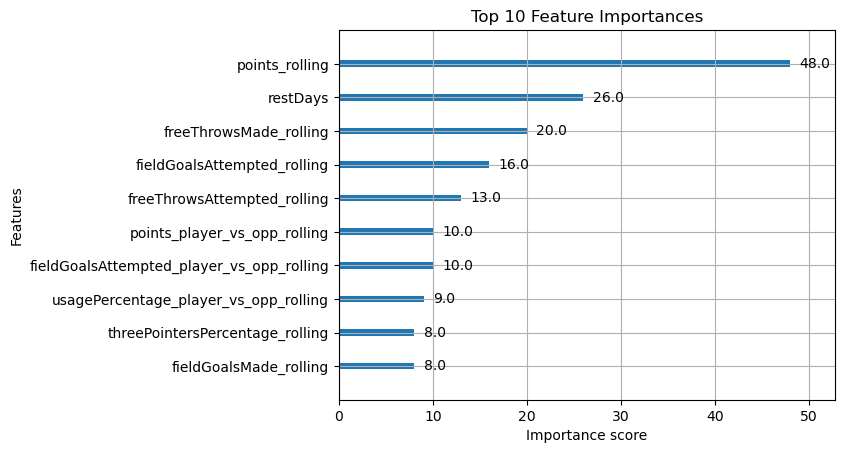

In [21]:
# Split into features (X) and target (y)
X = data[features]
y = data[target]

# Split train/test by time order to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Train the XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Evaluate baseline (rolling average)
y_baseline_pred = X_test[f"{target}_rolling"]
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)
print(f"\n{rolling_window}-game Average Baseline RMSE: {baseline_rmse:.2f}")
print(f"{rolling_window}-game Average Baseline MAE: {baseline_mae:.2f}")

# Improvement
rmse_improvement = baseline_rmse - rmse
mae_improvement = baseline_mae - mae
print(f"\nRMSE Improvement over baseline: {rmse_improvement:.2f}")
print(f"MAE Improvement over baseline: {mae_improvement:.2f}")

# Plot Feature Importance
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

/opt/anaconda3/envs/cs190a/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


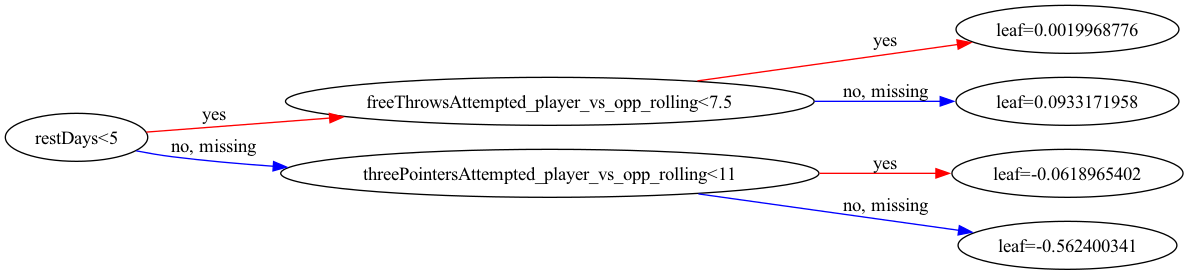

In [22]:
# Create Graphviz tree
dot = to_graphviz(model, num_trees=50, rankdir='LR')

# Render as PNG and show inline
dot.render('xgb_tree_50', format='png', cleanup=False)
display(Image(filename='xgb_tree_50.png'))

# K-Means Clustering Feature Enginnering

In [23]:
cluster_stats = [
    'points_rolling',
    'fieldGoalsAttempted_rolling',
    'threePointersAttempted_rolling',
    'freeThrowsAttempted_rolling',
    'trueShootingPercentage_rolling',
    'effectiveFieldGoalPercentage_rolling',
    
    'assists_rolling',
    'assistPercentage_rolling',
    'assistToTurnover_rolling',
    
    'reboundsOffensive_rolling',
    'reboundsDefensive_rolling',
    'steals_rolling',
    'blocks_rolling',
    'defensiveRating_rolling',
    
    'usagePercentage_rolling',
    'PIE_rolling',
    'plusMinusPoints_rolling',
    'netRating_rolling',

    'seconds_rolling',
    'pacePer40_rolling'
]

X = data[cluster_stats].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality while retaining ~88% variance
pca = PCA(n_components=0.88)
X_pca = pca.fit_transform(X_scaled)

# Apply K-Means clustering
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Assign cluster labels back to the corresponding rows in the original DataFrame
data.loc[X.index, 'cluster'] = cluster_labels
data['cluster'] = data['cluster'].astype('category')

In [24]:
data = pd.get_dummies(data, columns=["cluster"], prefix="cluster")

features += [col for col in data.columns if col.startswith("cluster_")]

data = data.dropna(subset=features + [target])

Test RMSE: 6.79
Test MAE: 5.22

15-game Average Baseline RMSE: 6.86
15-game Average Baseline MAE: 5.27

RMSE Improvement over baseline: 0.07
MAE Improvement over baseline: 0.05


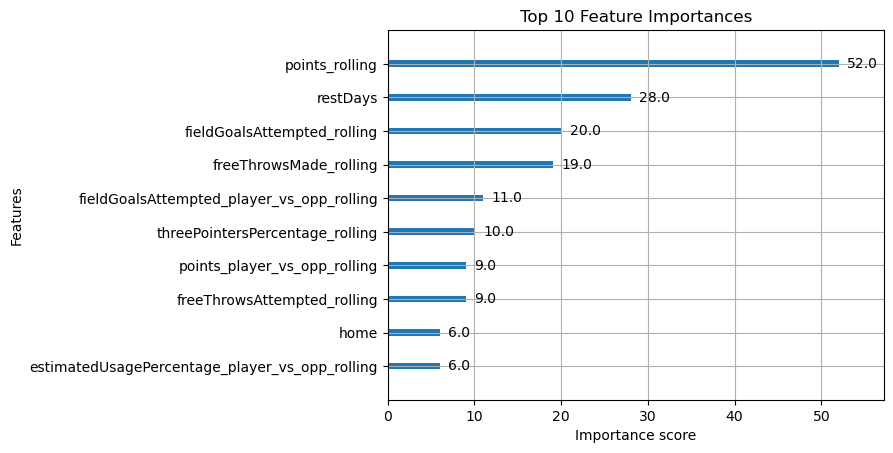

In [25]:
# Split into features (X) and target (y)
X = data[features]
y = data[target]

# Split train/test by time order to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Train the XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Evaluate baseline (rolling average)
y_baseline_pred = X_test[f"{target}_rolling"]
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)
print(f"\n{rolling_window}-game Average Baseline RMSE: {baseline_rmse:.2f}")
print(f"{rolling_window}-game Average Baseline MAE: {baseline_mae:.2f}")

# Improvement
rmse_improvement = baseline_rmse - rmse
mae_improvement = baseline_mae - mae
print(f"\nRMSE Improvement over baseline: {rmse_improvement:.2f}")
print(f"MAE Improvement over baseline: {mae_improvement:.2f}")

# Plot Feature Importance
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

# Parameter Tuning

In [26]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb = XGBRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=50,
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/envs/cs190a/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': np.float64(0.8814978068388948), 'learning_rate': np.float64(0.03418123569456745), 'max_depth': 3, 'n_estimators': 193, 'subsample': np.float64(0.9719553993230343)}


In [27]:
# Get best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE with best parameters: {rmse:.4f}")
print(f"Test MAE with best parameters: {mae:.4f}")


Test RMSE with best parameters: 6.7873
Test MAE with best parameters: 5.2201
